In [154]:
import csv
import os
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from tqdm import tqdm_notebook
import scipy.stats as sstats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter, defaultdict
from itertools import cycle, combinations
from operator import itemgetter
from sklearn import datasets, metrics, tree
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn import datasets
from apyori import apriori
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from sklearn.decomposition import NMF, LatentDirichletAllocation
pd.options.mode.chained_assignment = None 
import numpy as np 
import pandas as pd 
from time import time
import re
import string
import os
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
cmaps = OrderedDict()
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


mpl.style.use('seaborn-pastel')
sns.set_style('whitegrid')

# Basic preparations

This part contains checking null/unknown values, converting unix timestamp to usable one,
adding columns with lengths of text for easier access and removing profileName, because 
I consider it useless.

In [155]:
all_begs = ['product/productId: ', 'product/title: ', 
     'product/price: ', 'review/userId: ',
     'review/profileName: ', 'review/helpfulness: ',
     'review/score: ', 'review/time: ', 'review/summary: ',
     'review/text: ']
col_names = ['productID', 'title', 'price', 'userID', 'profileName', 'helpfulness', 'score',
                    'time', 'summary', 'text']

df = pd.read_csv("dataset.csv") 
df['time'] = pd.to_datetime(df['time'],unit='s')
df = df.drop(['profileName'], axis=1)
col_names.remove('profileName')
all_begs.remove('review/profileName: ')
df.head()

productID                                              title    price  \
0  B000JVER7W  Mobile Action MA730 Handset Manager - Bluetoot...  unknown   
1  B000JVER7W  Mobile Action MA730 Handset Manager - Bluetoot...  unknown   
2  B000JVER7W  Mobile Action MA730 Handset Manager - Bluetoot...  unknown   
3  B000924R5I  USB Data Cable for Sony-Ericsson Z600, Z500, Z...  unknown   
4  B000924R5I  USB Data Cable for Sony-Ericsson Z600, Z500, Z...  unknown   

           userID  helpfulness  score       time  \
0  A1RXYH9ROBAKEZ          0.0    1.0 2009-01-31   
1   A7L6E1KSJTAJ6          0.0    5.0 2007-10-04   
2  A2NOQQ7I6PU7CW          0.0    4.0 2007-08-10   
3  A29Q0CLOF0U8BN          0.8    4.0 2006-04-28   
4   ANNHJND2MHUI3          0.0    1.0 2007-03-12   

                                             summary  \
0                                         Don't buy!   
1  Mobile Action Bluetooth Mobile Phone Tool Soft...   
2                                               good   
3                        No instructions included...   
4                                   NOT A DATA CABLE   

                                                text  
0  First of all, the company took my money and se...  
1  Great product- tried others and this is a ten ...  
2  works real good....a little hard to set up...w...  
3  The price was right for this cable ($11.95+$4....  
4  this is NOT a DATA CABLE this is only a USB ch...

In [156]:
df.isnull().sum()

productID        0
title          547
price            0
userID           0
helpfulness      0
score            0
time             0
summary          3
text             0
dtype: int64

In [157]:
df["summary"].fillna("none", inplace = True) 
df.isnull().sum()

productID        0
title          547
price            0
userID           0
helpfulness      0
score            0
time             0
summary          0
text             0
dtype: int64

In [158]:
print(f'total amount of reviews: {df.shape[0]}\n\n')
for e in col_names:
    print(f'{len(df[e].unique())} unique values in column {str(e)}\n')


total amount of reviews: 78930


7438 unique values in column productID

7150 unique values in column title

944 unique values in column price

68041 unique values in column userID

768 unique values in column helpfulness

5 unique values in column score

4431 unique values in column time

60320 unique values in column summary

77390 unique values in column text



In [159]:
for e in col_names:
    unknowns = len(df.loc[df[e] == "unknown"])
    if unknowns > 0:
        print(f'{unknowns} unknown values in {e}\n')


43287 unknown values in price

2276 unknown values in userID



/home/julia/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [160]:
df['summary_len'] = [len(summary) for summary in df['summary']]
df['text_len'] = [len(text) for text in df['text']]

Since more than half of prices is unknown, I will create distinct dataframe for products with prices.

In [161]:
priced_df = df.loc[df['price'] != 'unknown']
priced_df['price'] = [float(e) for e in priced_df['price']]

products summary

In [162]:
product_df = df.groupby('productID').mean()
product_df

helpfulness     score  summary_len    text_len
productID                                                 
1588465934     0.750000  4.250000    32.750000  493.500000
B00000J3Q2     0.673181  3.800000    23.200000  642.666667
B00000J438     0.764444  3.200000    26.000000  619.000000
B00000JHVO     0.476667  3.700000    25.700000  532.900000
B00001OPI2     0.760000  4.000000    22.800000  236.400000
...                 ...       ...          ...         ...
B000TZ4D4U     0.833333  3.166667    25.500000  304.333333
B000TZ4D7M     0.166667  4.166667    14.416667  195.666667
B000TZ4D9K     0.250000  2.500000    14.250000  168.250000
B000UPBPUO     0.291667  3.000000    23.062500  306.937500
B000UUEH04     0.000000  5.000000    13.000000  192.000000

[7438 rows x 4 columns]

In [163]:
priced_product_df = priced_df.groupby('productID').mean()
priced_product_df

price  helpfulness     score  summary_len    text_len
productID                                                        
B00000J438   4.99     0.764444  3.200000    26.000000  619.000000
B00000JHVO  19.95     0.476667  3.700000    25.700000  532.900000
B00001W0EC   4.67     0.475275  1.500000    18.500000  356.166667
B00001W0EQ  29.23     0.511181  3.694444    26.870370  469.476852
B000022449   8.89     0.668859  3.818182    17.636364  344.272727
...           ...          ...       ...          ...         ...
B000TYXLTY   0.28     0.000000  4.000000    17.812500  186.562500
B000TZ4D4U  13.61     0.833333  3.166667    25.500000  304.333333
B000TZ4D7M   2.98     0.166667  4.166667    14.416667  195.666667
B000TZ4D9K   4.88     0.250000  2.500000    14.250000  168.250000
B000UPBPUO  19.99     0.291667  3.000000    23.062500  306.937500

[2855 rows x 5 columns]

# Basic informations

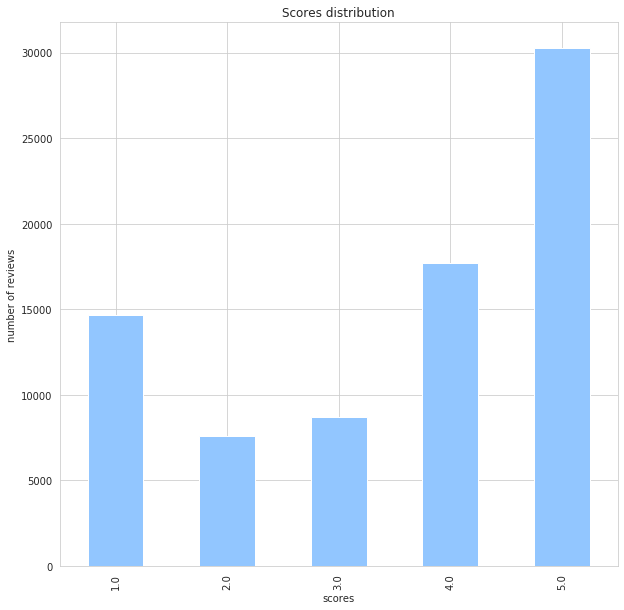

In [164]:
plt.figure(figsize=(10,10))
ax = df['score'].value_counts(sort=False).plot(kind='bar')
ax.set_title('Scores distribution')
ax.set_xlabel('scores')
ax.set_ylabel('number of reviews')
ax.figure.savefig('images/scoresdistribution.png')

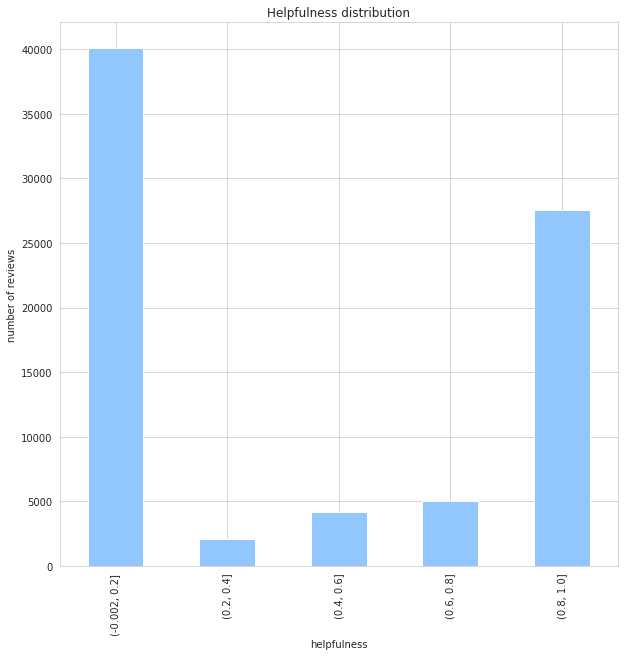

In [165]:
plt.figure(figsize=(10,10))
ax = df['helpfulness'].value_counts(sort=False,bins=5).plot(kind='bar')
ax.set_title('Helpfulness distribution')
ax.set_xlabel('helpfulness')
ax.set_ylabel('number of reviews')
ax.figure.savefig('images/helpfulnessdistribution.png')

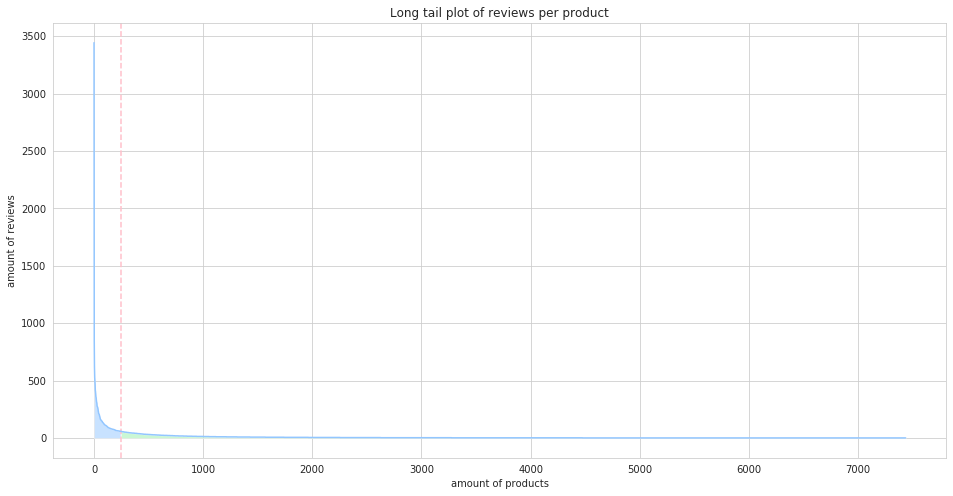

245 products out of 7438 owns 50% of reviews, which is only about 3% of all ratings
average amount of reviews per product: 10.61172358160796


In [166]:
ltp = pd.DataFrame(df['productID'].value_counts())
nums = np.array(ltp[ltp.columns[0]])
sumofrates = np.sum(nums)
i = 0
testsum = 0
while testsum<sumofrates/2:
    testsum += nums[i]
    i +=1
plt.figure(figsize=(16,8))
plt.axvline(x=i,c='pink',ls='--')
plt.plot(nums)
    
s1 = np.arange(0, i,1)
s2 = np.arange(i+1,len(nums),1)
plt.fill_between(s1,nums[:i],alpha=0.5)
plt.fill_between(s2,nums[i+1:len(nums)],alpha=0.5)
plt.title('Long tail plot of reviews per product')
plt.xlabel('amount of products')
plt.ylabel('amount of reviews')
plt.savefig('images/ltpproduct.png')
plt.show()
print(f'{i} products out of {len(nums)} owns 50% of reviews, which is only about {math.floor(i*100/len(nums))}% of all ratings')
print(f'average amount of reviews per product: {sum([e[0] for e in ltp.values])/len(ltp.values)}')

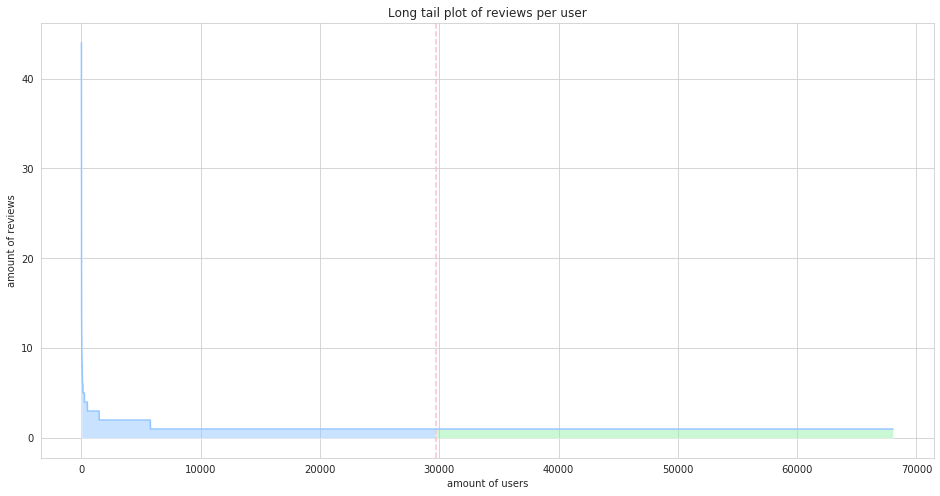


29713 users out of 68040 owns 50% of ratings, which is about 43% of all ratings
average amount of rated items per user: 1.126601998824221


In [167]:
# more than 2000 reviews has unknown author so we will ignore them
ltp = pd.DataFrame(df['userID'].value_counts())[1:]
nums = np.array(ltp[ltp.columns[0]])
sumofrates = np.sum(nums)
i = 0
testsum = 0
while testsum<sumofrates/2:
    testsum += nums[i]
    i +=1


plt.figure(figsize=(16,8))
plt.axvline(x=i,c='pink',ls='--')
plt.plot(nums)
    
s1 = np.arange(0, i,1)
s2 = np.arange(i+1,len(nums),1)
plt.fill_between(s1,nums[:i],alpha=0.5)
plt.fill_between(s2,nums[i+1:len(nums)],alpha=0.5)
plt.title('Long tail plot of reviews per user')
plt.xlabel('amount of users')
plt.ylabel('amount of reviews')
plt.savefig('images/ltpuser.png')
plt.show()
print(f'\n{i} users out of {len(nums)} owns 50% of ratings, which is about {math.floor(i*100/len(nums))}% of all ratings')
print(f'average amount of rated items per user: {sum([e[0] for e in ltp.values])/len(ltp.values)}')

# Lengths of reviews

In [168]:
df.groupby('score').mean().sort_values('helpfulness')

helpfulness  summary_len    text_len
score                                      
5.0       0.406484    22.810465  491.193501
1.0       0.420694    24.534514  492.397479
3.0       0.430210    26.153229  634.133272
2.0       0.440205    26.151335  618.803727
4.0       0.455714    24.602867  658.935034

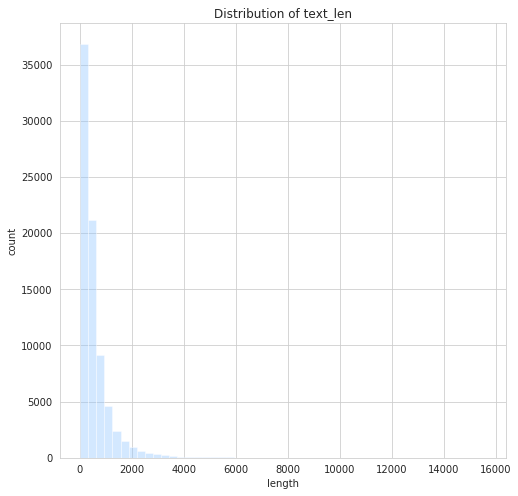

In [169]:
f, ax = plt.subplots(figsize=(8,8))
plt.ylabel('count')
sns.distplot(df['text_len'],kde=False)
plt.xlabel('length')
plt.title('Distribution of text_len')
plt.savefig('images/lengthdistribution.png')

# Most frequently occuring words

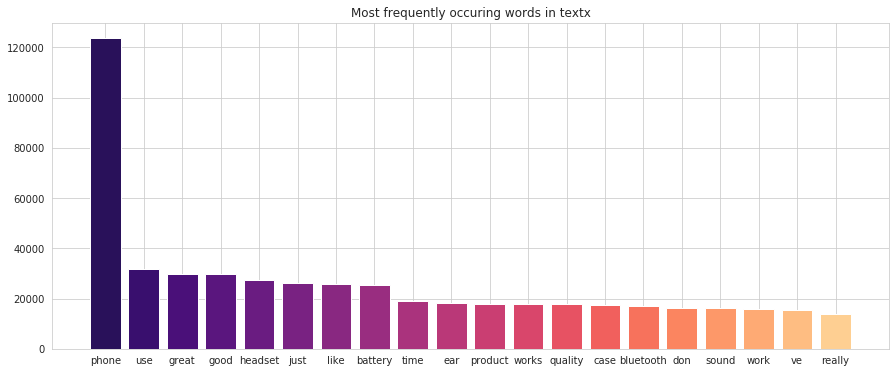

In [170]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.text)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq).head(20)
plt.figure(figsize=(15,6))
plt.bar(frequency[0].values, frequency[1].values, color=plt.cm.magma(np.arange(40,240,10)))
plt.title("Most frequently occuring words in textx")
plt.savefig('images/mostfrequentwordstext.png')
plt.show()

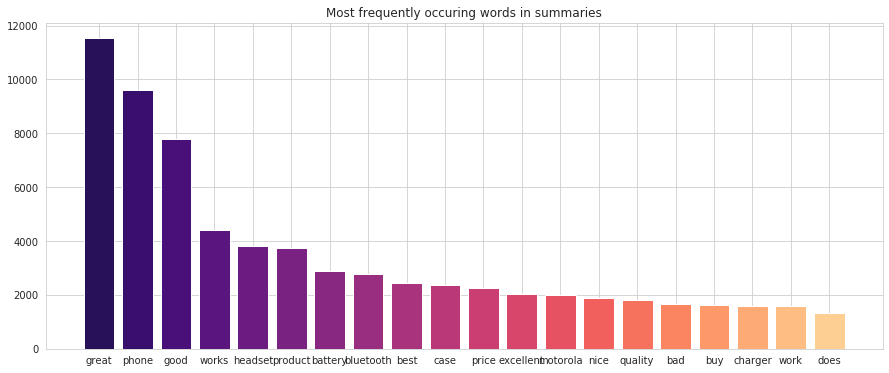

In [171]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.summary)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq).head(20)
plt.figure(figsize=(15,6))
plt.bar(frequency[0].values, frequency[1].values, color=plt.cm.magma(np.arange(40,240,10)))
plt.title("Most frequently occuring words in summaries")
plt.savefig('images/mostfrequentwordssummary.png')
plt.show()

# Checking correlations

In [172]:
def correls(df):
    print('helpfulness and score')
    print(np.corrcoef(np.array(df['helpfulness']), np.array(df['score'])))
    print()

    print('text_len and score')
    print(np.corrcoef(np.array(df['text_len']), np.array(df['score'])))
    print()

    print('summary_len and score')
    print(np.corrcoef(np.array(df['summary_len']), np.array(df['score'])))
    print()

    print('helpfulness and text_len')
    print(np.corrcoef(np.array(df['helpfulness']), np.array(df['text_len'])))
    print()
    
    print('helpfulness and summary_len')
    print(np.corrcoef(np.array(df['summary_len']), np.array(df['helpfulness'])))
    print()



correls(df)


helpfulness and score
[[ 1.        -0.0111176]
 [-0.0111176  1.       ]]

text_len and score
[[ 1.         -0.00919608]
 [-0.00919608  1.        ]]

summary_len and score
[[ 1.         -0.06104361]
 [-0.06104361  1.        ]]

helpfulness and text_len
[[1.        0.2766156]
 [0.2766156 1.       ]]

helpfulness and summary_len
[[1.       0.125153]
 [0.125153 1.      ]]



correlations for product_df

In [173]:
correls(product_df)

helpfulness and score
[[ 1.         -0.12334904]
 [-0.12334904  1.        ]]

text_len and score
[[ 1.         -0.02995685]
 [-0.02995685  1.        ]]

summary_len and score
[[ 1.         -0.07475427]
 [-0.07475427  1.        ]]

helpfulness and text_len
[[1.         0.25593154]
 [0.25593154 1.        ]]

helpfulness and summary_len
[[1.         0.13452342]
 [0.13452342 1.        ]]



correlations for priced_product_df

In [174]:
priced_correls(priced_product_df)

price and score
[[1.         0.02837974]
 [0.02837974 1.        ]]

price and text_len
[[1.         0.21553536]
 [0.21553536 1.        ]]

price and summary_len
[[1.         0.07828921]
 [0.07828921 1.        ]]

price and helpfulness
[[1.         0.09691404]
 [0.09691404 1.        ]]



In [175]:
bins = [e/10 for e in range(0,11)]
pd.DataFrame(df.groupby(pd.cut(df.helpfulness, bins)).mean()['text_len'])

text_len
helpfulness             
(0.0, 0.1]    333.877256
(0.1, 0.2]    420.520891
(0.2, 0.3]    521.292781
(0.3, 0.4]    515.510052
(0.4, 0.5]    517.201689
(0.5, 0.6]    739.409424
(0.6, 0.7]    713.820971
(0.7, 0.8]    840.279062
(0.8, 0.9]   1052.555596
(0.9, 1.0]    752.125800

In [176]:
bins = [e/10 for e in range(1,11,2)]
df.groupby(pd.cut(df.helpfulness, bins)).mean()

helpfulness     score  summary_len    text_len
helpfulness                                                
(0.1, 0.3]      0.210826  2.635061    24.448158  471.937926
(0.3, 0.5]      0.450776  2.863907    24.567716  516.701387
(0.5, 0.7]      0.637803  2.874164    26.171074  721.605925
(0.7, 0.9]      0.809942  3.256943    27.808457  943.925999

# Reviews on timeseries

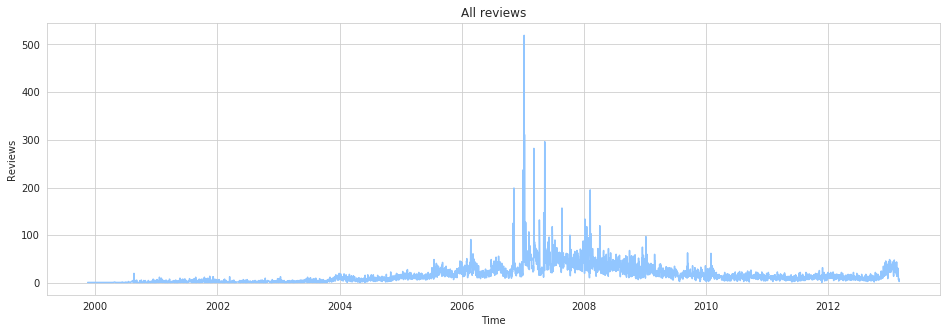

In [177]:
t = pd.DataFrame(df.groupby('time').count()['productID'])
plt.figure(figsize=(16,5))
plt.plot(t.index, t.values)
plt.gca().set(title='All reviews', xlabel='Time', ylabel='Reviews')
plt.savefig('images/allreviewstimeseries.png')
plt.show()

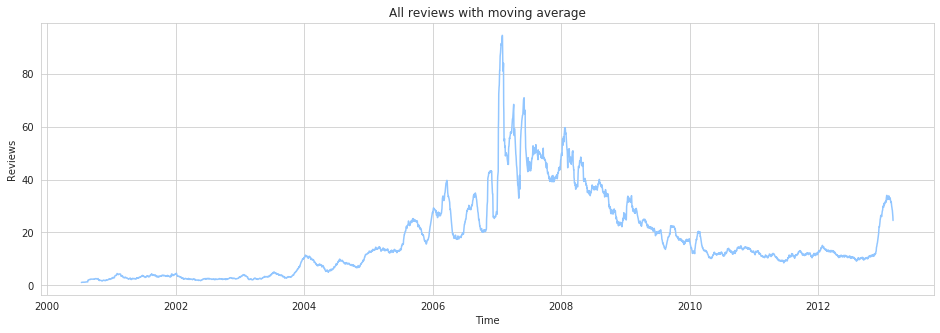

In [178]:
t = pd.DataFrame(df.groupby('time').count()['productID'])
t['mavg'] = t['productID'].rolling(30).mean()
plt.figure(figsize=(16,5))
plt.plot(t.index, t['mavg'])
plt.gca().set(title='All reviews with moving average', xlabel='Time', ylabel='Reviews')
plt.savefig('images/allreviewstimeseriesma.png')
plt.show()

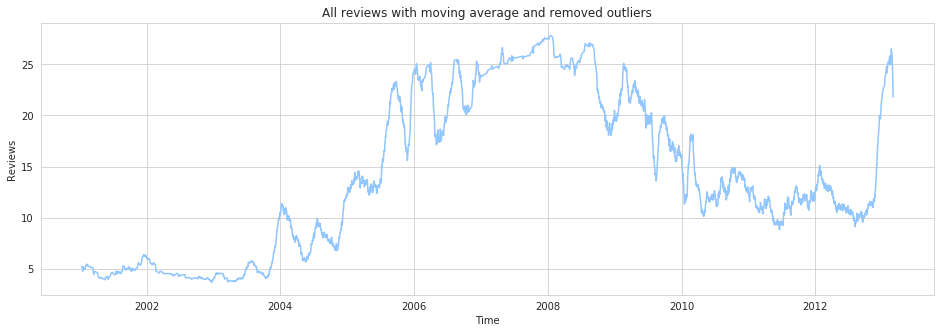

In [179]:
x = pd.DataFrame(t.loc[t['productID'].between(t['productID'].quantile(.15), t['productID'].quantile(.85))])
x['mavg'] = x['productID'].rolling(30).mean()
plt.figure(figsize=(16,5))
plt.plot(x.index, x['mavg'])
plt.gca().set(title='All reviews with moving average and removed outliers', xlabel='Time', ylabel='Reviews')
plt.savefig('images/allreviewstimeseriesmaro.png')
plt.show()

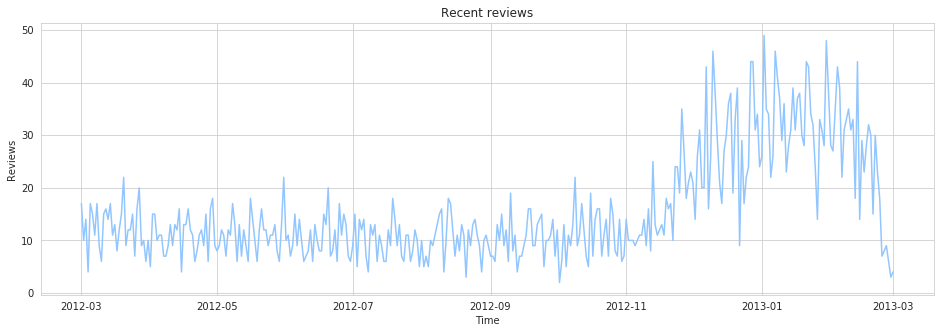

In [180]:
t = df.groupby('time').count()['productID']
t = pd.DataFrame(t.loc[t.index >= '2012-03-01'])
plt.figure(figsize=(16,5))
plt.plot(t.index, t.values)
plt.gca().set(title='Recent reviews', xlabel='Time', ylabel='Reviews')
plt.savefig('images/recentreviewstimeseries.png')
plt.show()

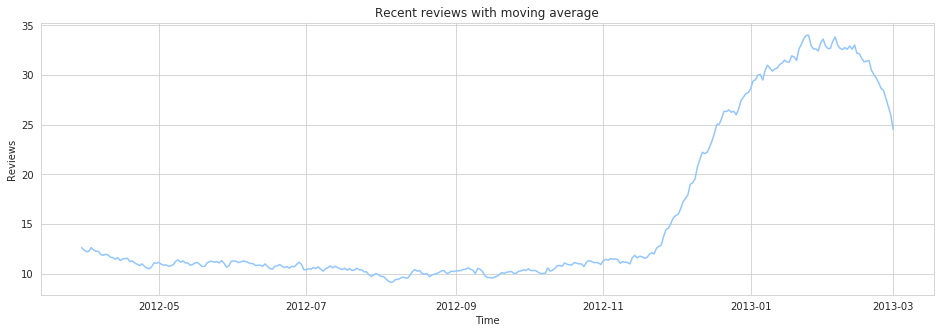

In [181]:
t = df.groupby('time').count()['productID']
t = pd.DataFrame(t.loc[t.index >= '2012-03-01'])
t['mavg'] = t['productID'].rolling(30).mean()
plt.figure(figsize=(16,5))
plt.plot(t.index, t['mavg'])
plt.gca().set(title='Recent reviews with moving average', xlabel='Time', ylabel='Reviews')
plt.savefig('images/recentreviewstimeseriesma.png')
plt.show()

# Prices

In [182]:
priced_product_df['price'].describe()

count    2855.000000
mean       15.271555
std        33.386855
min         0.010000
25%         3.990000
50%         7.550000
75%        14.975000
max       569.950000
Name: price, dtype: float64

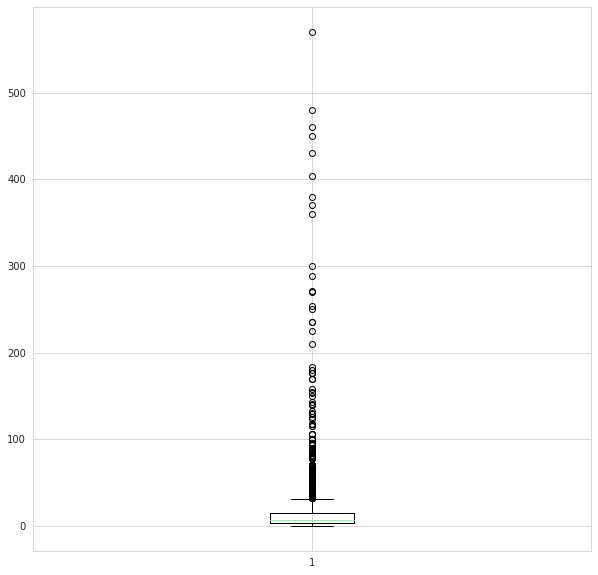

In [183]:
plt.figure(figsize=(10,10))
plt.boxplot(priced_product_df['price'])
plt.show()